# GiveMeSomeCredit challenge

We have historical data of a retail store credit card program. The problem concerns the loss from a customer’s default on his debt, which prevents the store from collecting payment for its products and services.

The data comprises one record for each customer — a sample of 150k customers from the store’s database.

The following table reproduces the data description available from the Kaggle page.

Column | Description | Type
:- | :- | :-
**SeriousDlqin2yrs** | Person experienced 90 days past due delinquency or worse | Y/N
**RevolvingUtilizationOfUnsecuredLines** | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits  | percentage
**age** |Age of borrower in years  | integer
**NumberOfTime30-59DaysPastDueNotWorse** |  Number of times borrower has been 30-59 days past due but no worse in the last 2 years. |integer
**DebtRatio** | Monthly debt payments, alimony, living costs divided by monthy gross income  | percentage
**MonthlyIncome** | Monthly income  |real
**NumberOfOpenCreditLinesAndLoans** | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)  | integer
**NumberOfTimes90DaysLate** | Number of times borrower has been 90 days or more past due. | integer
**NumberRealEstateLoansOrLines** | Number of mortgage and real estate loans including home equity lines of credit  |integer
**NumberOfTime60-89DaysPastDueNotWorse** | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer
**NumberOfDependents** | Number of dependents in family excluding themselves (spouse, children etc.) |integer


**Note:** As I went through the exploration process, I have written decision notes, but haven’t coded it in the same cell. I put all decision code in a class after the exploration. That way I keep all data transformations in a single class, which is nice to keep track of everything.

# Import main libs and read the training set

In [1]:
from IPython.display import display, Markdown
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

seed = 42

In [117]:
from sklearn.model_selection import train_test_split

def read_dataset(filename, drop_cols=None, verbose=2):
    """Reads the training and the test set for this problem"""
    data = pd.read_csv(filename, index_col=0)
    data.columns = [c.replace('-', '') for c in data.columns]
    # Reorder columns
    data = data.iloc[:, [2, 10, 1, 6, 8, 3, 9, 7, 5, 4, 0]]
    if verbose > 0:
        print('Read "{}" with shape {}'.format(filename, data.shape))
    if verbose > 1:
        print(data.dtypes)
    if drop_cols:
        data.drop(drop_cols, axis=1, inplace=True)
    return data

def train_validate_test_split(X, y, test_size=0.3):
    """Splits X into Train, Validate & Test where Validate is as large as the Test set"""
    model_size = 1 - test_size
    X_model, X_test, y_model, y_test = train_test_split(
        X, y, train_size=model_size, random_state=seed)
    X_train, X_validate, y_train, y_validate = train_test_split(
        X_model, y_model, train_size=2 - 1 / model_size, random_state=seed)
    display(Markdown('**All:** {} {}'.format(X.shape, y.shape)))
    display(Markdown('**Model:** {} {} — **Train:** {} {} — **Validate:** {} {}'.format(
        X_model.shape, y_model.shape, X_train.shape, y_train.shape, 
        X_validate.shape, y_validate.shape)))
    display(Markdown('**Test:** {} {}'.format(X_test.shape, y_test.shape)))
    return {'all': (X, y),
            'model': (X_model, y_model),
            'train': (X_train, y_train),
            'validate': (X_validate, y_validate),
            'test': (X_test, y_test)}

def split_column(data, colname):
    """Splits |data|, where left-hand side does not contain |colname|, and the 
    right-hand side is the |colname| column."""
    return data.drop(colname, axis=1), data[colname]

raw = read_dataset('data/cs-training.csv')
splits = train_validate_test_split(*split_column(raw, 'SeriousDlqin2yrs'))
model_data = pd.concat(splits['model'], axis=1).reset_index(drop=True)

Read "data/cs-training.csv" with shape (150000, 11)
age                                       int64
NumberOfDependents                      float64
RevolvingUtilizationOfUnsecuredLines    float64
NumberOfOpenCreditLinesAndLoans           int64
NumberRealEstateLoansOrLines              int64
NumberOfTime3059DaysPastDueNotWorse       int64
NumberOfTime6089DaysPastDueNotWorse       int64
NumberOfTimes90DaysLate                   int64
MonthlyIncome                           float64
DebtRatio                               float64
SeriousDlqin2yrs                          int64
dtype: object


**All:** (150000, 10) (150000,)

**Model:** (105000, 10) (105000,) — **Train:** (60000, 10) (60000,) — **Validate:** (45000, 10) (45000,)

**Test:** (45000, 10) (45000,)

In [3]:
model_data.describe()

,age,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime3059DaysPastDueNotWorse,NumberOfTime6089DaysPastDueNotWorse,NumberOfTimes90DaysLate,MonthlyIncome,DebtRatio,SeriousDlqin2yrs
count,105000.000000,102266.000000,105000.000000,105000.000000,105000.000000,105000.000000,105000.000000,105000.000000,8.427100e+04,105000.000000,105000.000000
mean,52.300552,0.758033,5.895100,8.457590,1.018352,0.432781,0.249962,0.276581,6.668039e+03,348.912413,0.067105
std,14.779812,1.117895,259.301466,5.144765,1.129260,4.307712,4.270922,4.285134,1.565735e+04,1759.104884,0.250205
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,41.000000,0.000000,0.029939,5.000000,0.000000,0.000000,0.000000,0.000000,3.400000e+03,0.175365,0.000000
50%,52.000000,0.000000,0.154974,8.000000,1.000000,0.000000,0.000000,0.000000,5.400000e+03,0.367054,0.000000
75%,63.000000,1.000000,0.559475,11.000000,2.000000,0.000000,0.000000,0.000000,8.250000e+03,0.870328,0.000000
max,109.000000,13.000000,50708.000000,58.000000,54.000000,98.000000,98.000000,98.000000,3.008750e+06,307001.000000,1.000000


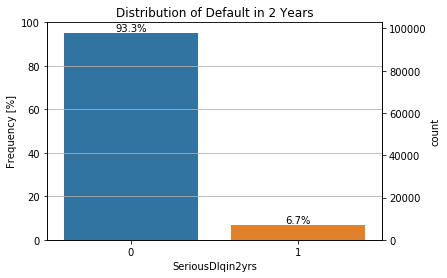

In [4]:
def add_freq_axis(data, ax):
    ncount = len(data)
    ax2 = ax.twinx()
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y), 
                    ha='center', va='bottom')
    ax2.set_ylim(0, 100)
    ax2.grid(None)
    
ax = sns.countplot(model_data.SeriousDlqin2yrs)
ax.set_title('Distribution of Default in 2 Years')
add_freq_axis(model_data, ax)

# Missing data exploration

In [5]:
import missingno as msno

In [6]:
model_data.isnull().sum()

age                                         0
NumberOfDependents                       2734
RevolvingUtilizationOfUnsecuredLines        0
NumberOfOpenCreditLinesAndLoans             0
NumberRealEstateLoansOrLines                0
NumberOfTime3059DaysPastDueNotWorse         0
NumberOfTime6089DaysPastDueNotWorse         0
NumberOfTimes90DaysLate                     0
MonthlyIncome                           20729
DebtRatio                                   0
SeriousDlqin2yrs                            0
dtype: int64

Only two columns contains missings. Let’s look a sample of rows.

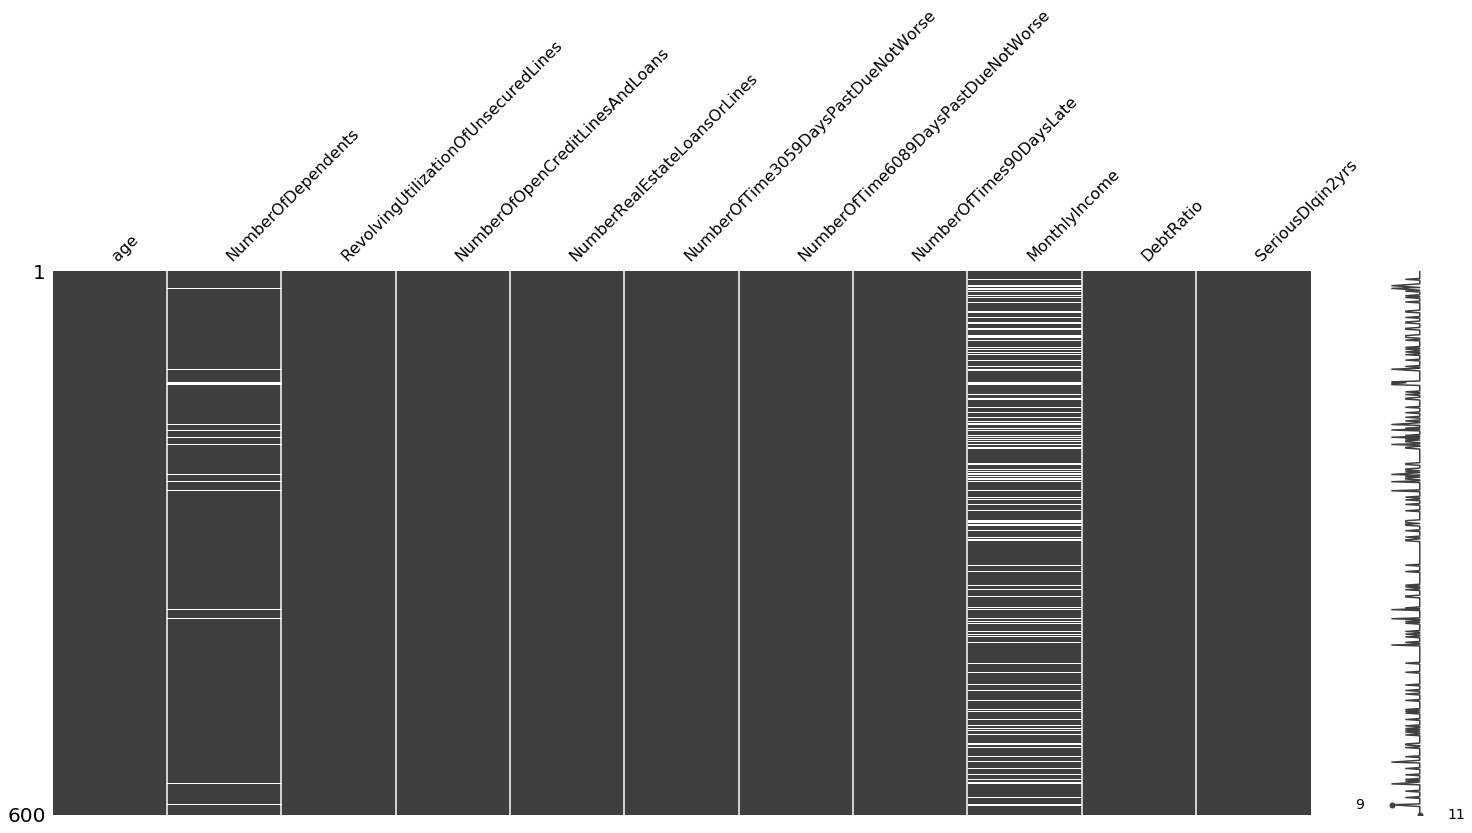

In [7]:
msno.matrix(model_data.groupby('SeriousDlqin2yrs').apply(lambda x: x.sample(n=300)))

Also, let’s see the correlation of missing events.

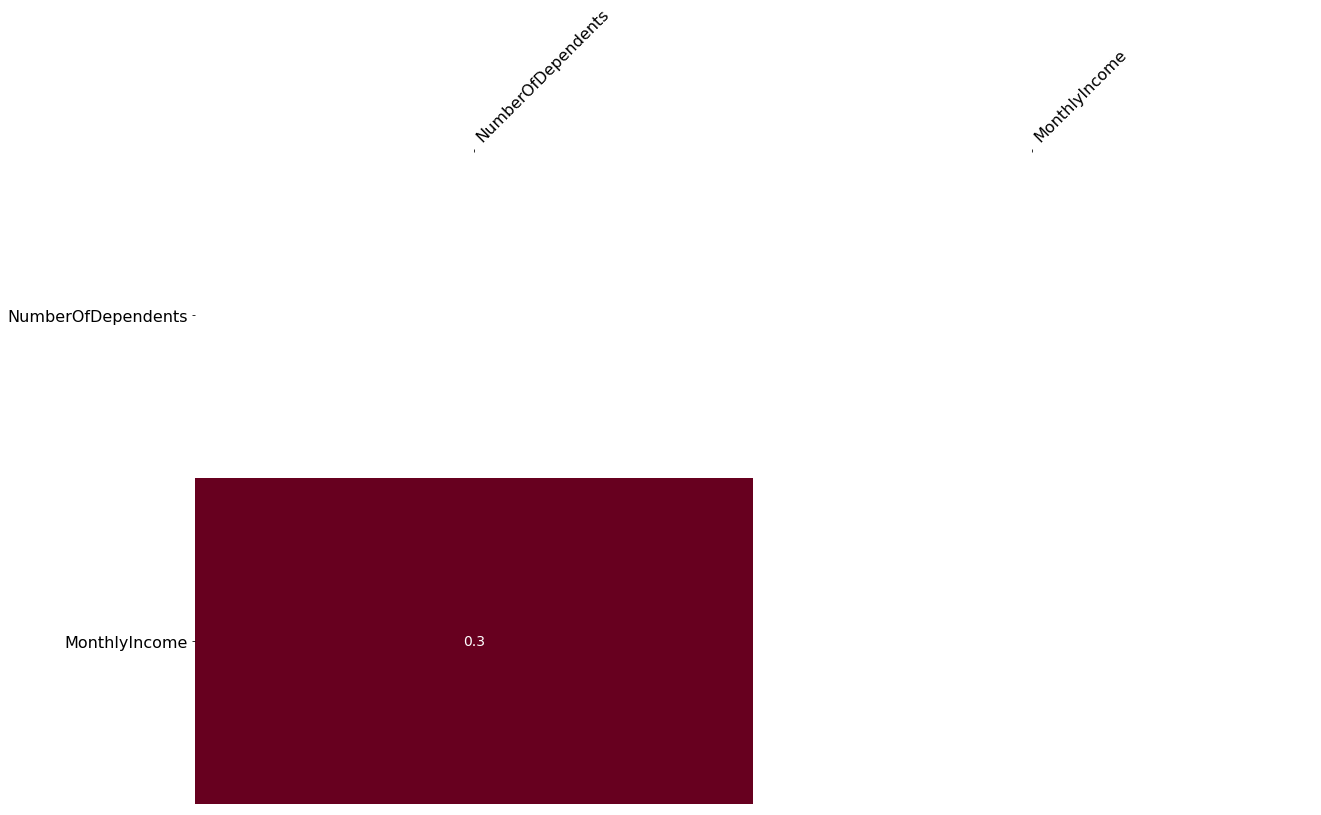

In [8]:
msno.heatmap(model_data)

# Exploring the features

## Age

In [9]:
model_data.age.describe()

count    105000.000000
mean         52.300552
std          14.779812
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

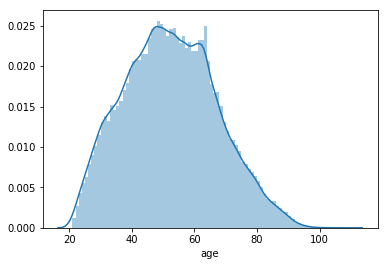

In [10]:
sns.distplot(model_data.age, bins=np.ptp(model_data.age));

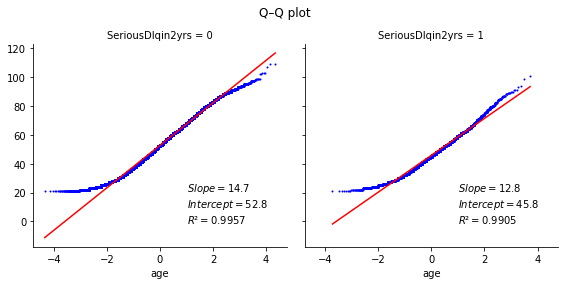

In [11]:
from scipy import stats

def qqplot(x, **kwargs):
    ax = plt.gca()
    res = stats.probplot(x, plot=ax, fit=True)
    ax.get_lines()[0].set_markersize(1.0)
    ax.text(1, 0, '$Slope = {:.3}$\n$Intercept = {:.3}$\n$R² = {:.4}$'.format(*res[1]))

g = sns.FacetGrid(model_data, col='SeriousDlqin2yrs', size=4)
g.map(qqplot, 'age');
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Q–Q plot');

The customer age has no missing values, and **it follows a normal distribution** as the Q–Q plot shows.

But it might happen in the test data some outliers. Let’s see the box plot for the customers’ age.

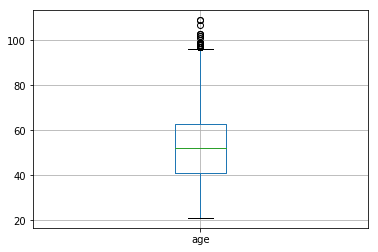

In [12]:
model_data.boxplot('age');

Let’s compute the Interquartile Range (IQR).

In [13]:
Q1 = model_data.age.quantile(0.25)
Q3 = model_data.age.quantile(0.75)
IQR = Q3 - Q1
print('IQR: {}, Min: {:.2}, Max: {:.3}'.format(IQR, Q1 - IQR * 1.5, Q3 + IQR * 1.5))

IQR: 22.0, Min: 8.0, Max: 96.0


Also, let’s check the tail value counts.

In [14]:
model_data.age.value_counts(sort=True).tail(10)

95     35
97     13
96     12
99      7
98      4
103     3
109     2
102     2
101     1
107     1
Name: age, dtype: int64

### Outlier treatment for Age

The 3rd quartile (Q3) is positioned at .675σ for a normal distribution (`R: qnorm(0.75)`). The IQR (Q3 – Q1) represents 2 × .675σ = 1.35σ (`R: qnorm(0.75) - qnorm(0.25)`).

The outlier threshold for a box plot is set to be 1.5 × IQR above the Q3: .675σ + 1.5 × 1.35σ = 2.7σ.
This level would declare .7% of the measurements to be outliers:

```
Q1 <- qnorm(0.25)  # -0.6744898
Q3 <- qnorm(0.75)  # +0.6744898
Q <- pnorm(Q3 + 1.5 * (Q3 - Q1))  # 0.9965117
# (1 - Q) is 0.35% for each side, so removing for both sides:
outliers <- (1 - Q) * 2  # 0.006976603
```

In our case, the upper bound would be:

In [15]:
Q1 = model_data.age.quantile(0.25)
Q3 = model_data.age.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print('Upper bound for age: {}, customer age outlier count: {}'.format(
    upper_bound, np.sum(model_data.age > upper_bound)))

Upper bound for age: 96.0, customer age outlier count: 33


Alternatively, I can be more conservative removing only customers at the 0.01% right-hand side:

In [16]:
Q = model_data.age.quantile(0.9999)
print('Upper bound for age: {}, customer age outlier count: {}'.format(
    Q, np.sum(model_data.age > Q)))

Upper bound for age: 99.0, customer age outlier count: 9


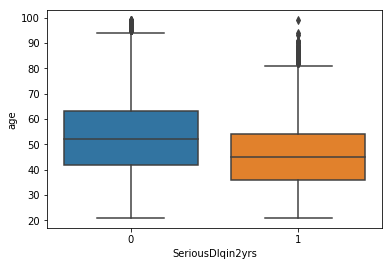

In [17]:
sns.boxplot(x='SeriousDlqin2yrs', y='age', data=model_data[model_data.age <= Q]);

### Conclusion for Age

The customer age has no missing values, and it follows a normal distribution as the Q–Q plot shows. But some outliers might appear, which we might remove using a 7% or 99.99% percentile fence.

Additionally, it would not make sense in this data a 15-year-old or younger credit-card customer, so I can remove as well, if it any — we haven’t seen any in our exploration, but it could happen on the test data.

Finally, it seems the age will be a good predictor for this problem.

**Decision:** drop customers younger than 15 or older than 99.99% quantile (99 in our exploration; however, this value should be bound to the training data).

## NumberOfDependents

In [18]:
model_data.NumberOfDependents.describe()

count    102266.000000
mean          0.758033
std           1.117895
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          13.000000
Name: NumberOfDependents, dtype: float64

This variable also contains missings:

In [19]:
null = model_data.NumberOfDependents.isnull()
null.sum(), null.mean()

(2734, 0.026038095238095239)

Since this variables is the number of dependents, we can simply impute missings with zero.

**Decision:** impute missings with 0.

## RevolvingUtilizationOfUnsecuredLines

In [20]:
model_data.RevolvingUtilizationOfUnsecuredLines.describe()

count    105000.000000
mean          5.895100
std         259.301466
min           0.000000
25%           0.029939
50%           0.154974
75%           0.559475
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

The **revolving utilization of unsecured lines** is a percentage, as the data description says, thus it should be in the range `[0, 1]`.  We clearly have abnormal values higher than 1:

In [21]:
(model_data.RevolvingUtilizationOfUnsecuredLines > 1).sum()

2318

I am interested to check whether how good these 2318 customers are:

Selection shape: (2318, 11)
   RevolvingUtilizationOfUnsecuredLines  SeriousDlqin2yrs
0                                 False                 0
1                                 False                 0
2                                 False                 0
3                                 False                 0
4                                 False                 0


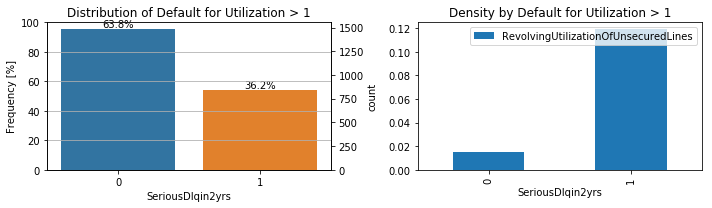

In [22]:
def get_dist_and_density_by_default(selection, description):
    selected = model_data[selection]
    print('Selection shape:', selected.shape)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    sns.countplot(selected.SeriousDlqin2yrs, ax=ax[0])
    ax[0].set_title('Distribution of Default for {}'.format(description))
    add_freq_axis(selected, ax[0])
    print(pd.concat([pd.DataFrame(selection), model_data.SeriousDlqin2yrs], axis=1).head())
    pd.concat([pd.DataFrame(selection), model_data.SeriousDlqin2yrs], axis=1)\
        .groupby('SeriousDlqin2yrs').mean().plot.bar(ax=ax[1])
    ax[1].set_title('Density by Default for {}'.format(description))
    plt.tight_layout()

get_dist_and_density_by_default(
    model_data.RevolvingUtilizationOfUnsecuredLines > 1.0, 'Utilization > 1')

36.2% of those with utilization above 100% have defaulted. What about customers with utilization at 100%?

Selection shape: (7217, 11)
       0  SeriousDlqin2yrs
0  False                 0
1  False                 0
2  False                 0
3  False                 0
4  False                 0


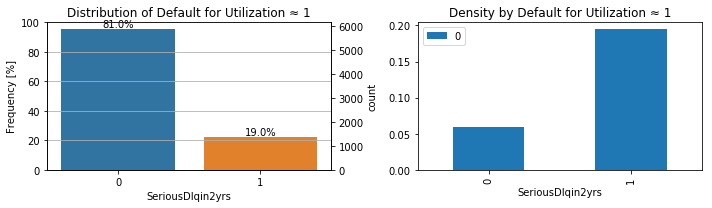

In [23]:
get_dist_and_density_by_default(
    np.isclose(model_data.RevolvingUtilizationOfUnsecuredLines, 1.0), 'Utilization ≈ 1')

Let’s look at its distribution of customers with utilization within 0% and 100% of utilization.

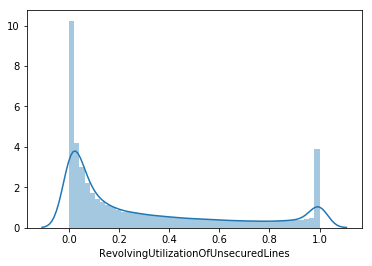

In [24]:
selection = model_data.RevolvingUtilizationOfUnsecuredLines <= 1
sns.distplot(model_data[selection].RevolvingUtilizationOfUnsecuredLines);

`RevolvingUtilizationOfUnsecuredLines` does not follow a normal distribution.

**Decision:** values above 1 should be transformed to a bit higher than 1, to keep differenciable from the others that are already 1.

## NumberOfOpenCreditLinesAndLoans

In [25]:
model_data.NumberOfOpenCreditLinesAndLoans.describe()

count    105000.000000
mean          8.457590
std           5.144765
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

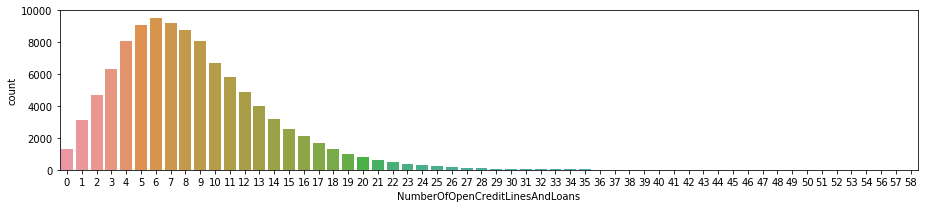

In [26]:
fig, ax = plt.subplots(figsize=(13, 3))
sns.countplot(model_data.NumberOfOpenCreditLinesAndLoans, ax=ax)
plt.tight_layout()

Let’s look at the upper values.

In [27]:
model_data.NumberOfOpenCreditLinesAndLoans.value_counts(sort=False).tail(10)

48    5
49    2
50    1
51    2
52    2
53    1
54    3
56    2
57    1
58    1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

This distribution seems okay and nothing will be done.

## NumberRealEstateLoansOrLines

In [28]:
model_data.NumberRealEstateLoansOrLines.describe()

count    105000.000000
mean          1.018352
std           1.129260
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [29]:
model_data.NumberRealEstateLoansOrLines.value_counts(sort=False)

0     39401
1     36543
2     22019
3      4453
4      1529
5       512
6       225
7       116
8        62
9        49
10       25
11       16
12       15
13       11
14        5
15        5
16        2
17        3
18        2
20        2
23        1
25        2
32        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

A single customer seems to have 54 real estate loans or lines. Except for him, most seem to be up to 32, so we can drop this single record.

**Decision:** drop records where `NumberRealEstateLoansOrLines >= 54`

## NumberOfTime30–59DaysPastDueNotWorse

In [30]:
model_data.NumberOfTime3059DaysPastDueNotWorse.describe()

count    105000.000000
mean          0.432781
std           4.307712
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime3059DaysPastDueNotWorse, dtype: float64

In [31]:
model_data.NumberOfTime3059DaysPastDueNotWorse.value_counts(sort=False)

0     88137
1     11221
2      3267
3      1229
4       539
5       233
6       102
7        39
8        19
9         9
10        3
11        1
12        2
96        3
98      196
Name: NumberOfTime3059DaysPastDueNotWorse, dtype: int64

It seems highly unlikely a customer who would become 96 or 98 times 30–59 days paste due.

Let’s see the distribution without 96 and 98, which might be typos or missing-value codes.

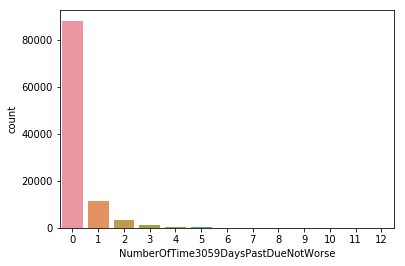

In [32]:
selection = model_data.NumberOfTime3059DaysPastDueNotWorse < 96
sns.countplot(model_data[selection].NumberOfTime3059DaysPastDueNotWorse);

**Decision:** values 96 and 98 should be imputed to 0.

## NumberOfTime60–89DaysPastDueNotWorse

In [33]:
model_data.NumberOfTime6089DaysPastDueNotWorse.describe()

count    105000.000000
mean          0.249962
std           4.270922
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime6089DaysPastDueNotWorse, dtype: float64

In [34]:
model_data.NumberOfTime6089DaysPastDueNotWorse.value_counts(sort=False)

0     99684
1      4011
2       780
3       212
4        67
5        25
6        12
7         6
8         2
9         1
11        1
96        3
98      196
Name: NumberOfTime6089DaysPastDueNotWorse, dtype: int64

In [35]:
selection = model_data.NumberOfTime6089DaysPastDueNotWorse < 96
model_data[selection].NumberOfTime6089DaysPastDueNotWorse.value_counts(sort=False)

0     99684
1      4011
2       780
3       212
4        67
5        25
6        12
7         6
8         2
9         1
11        1
Name: NumberOfTime6089DaysPastDueNotWorse, dtype: int64

**Decision:** NumberOfTime6089DaysPastDueNotWorse is very much like NumberOfTime3059DaysPastDueNotWorse, thus we will apply the same decisions here for the values 96 and 98.

## NumberOfTimes90DaysLate

In [36]:
model_data.NumberOfTimes90DaysLate.describe()

count    105000.000000
mean          0.276581
std           4.285134
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

In [37]:
model_data.NumberOfTimes90DaysLate.value_counts(sort=False)

0     99132
1      3688
2      1088
3       455
4       215
5        90
6        57
7        29
8        13
9        16
10        8
11        3
13        3
14        1
15        2
17        1
96        3
98      196
Name: NumberOfTimes90DaysLate, dtype: int64

In [38]:
selection = model_data.NumberOfTimes90DaysLate < 96
model_data[selection].NumberOfTimes90DaysLate.value_counts(sort=False)

0     99132
1      3688
2      1088
3       455
4       215
5        90
6        57
7        29
8        13
9        16
10        8
11        3
13        3
14        1
15        2
17        1
Name: NumberOfTimes90DaysLate, dtype: int64

**Decision:** we should impute values 96 and 98, perhaps in the same way we do for `"NumberOfTimes.*"`.

# *New feature:* NumberOfTimes30DaysLate

Let’s explore the possibility of creating a new feature that sums all `"NumberOfTime.s*"` features.

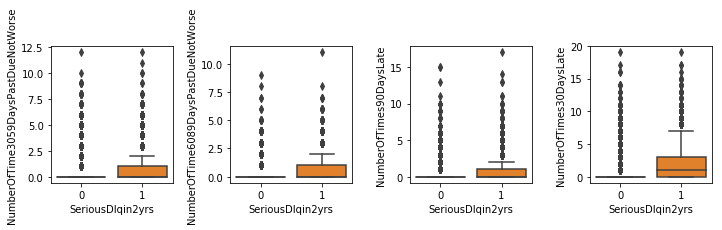

In [39]:
over = model_data.copy()
over['NumberOfTimes30DaysLate'] = over.NumberOfTime3059DaysPastDueNotWorse + \
    over.NumberOfTime6089DaysPastDueNotWorse + \
    over.NumberOfTimes90DaysLate

over_cols = ['NumberOfTime3059DaysPastDueNotWorse', 
             'NumberOfTime6089DaysPastDueNotWorse',
             'NumberOfTimes90DaysLate', 
             'NumberOfTimes30DaysLate']

for i, col in enumerate(over_cols):
    selected = np.where(over[col].values > 95)
    over[col].values[selected] = 0

fig, ax = plt.subplots(1, 4, figsize=(10, 3))
for i, col in enumerate(over_cols):
    sns.boxplot(x='SeriousDlqin2yrs', y=col, data=over, ax=ax[i])
plt.tight_layout()

**Decision:** we should create this new feature after preparing the required features.

## MonthlyIncome

In [40]:
model_data.MonthlyIncome.describe(include='all')

count    8.427100e+04
mean     6.668039e+03
std      1.565735e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.250000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

This variable contains missing values:

In [41]:
null = model_data.MonthlyIncome.isnull()
null.sum(), null.mean()

(20729, 0.19741904761904763)

20k missings, a fraction of 19.77%.

In [42]:
stats.skew(model_data.MonthlyIncome[~null])

120.02205212656607

The **montly income** has the mean value skewed by the people who earn a lot. 

**Decision:** we should imput the montly income missings with the median value.

## DebtRatio

In [43]:
model_data.DebtRatio.describe()

count    105000.000000
mean        348.912413
std        1759.104884
min           0.000000
25%           0.175365
50%           0.367054
75%           0.870328
max      307001.000000
Name: DebtRatio, dtype: float64

Recalling that the **debt ratio** here is the monthly debt payments, alimony, living costs divided by monthy gross income, we might have values above 100%, but not that high.

For instance, let’s see how much have a debt ratio higher than 2400% — two years of montly income.

In [44]:
(model_data.DebtRatio > 2400).sum(), (model_data.DebtRatio > 2400).mean()

(5396, 0.051390476190476188)

Probably the dataset was constructed considered missing `montly gross income` as `1` when they divided. 

We actually have the **monthly income** with 19.8% missing values.  I think we can match the missings of the monthly income with the **debt ratio**.  Also, I think the actual debt ratio was rounded before diving. But since the **debt ratio** is a percentage, all those debt ratios matching the missing monthly incomes should be integers.

Let’s check whether my premise holds:

In [45]:
null_income = model_data.MonthlyIncome.isnull()
selected = model_data.DebtRatio[null_income]
display(selected.describe())
# I won’t use |numpy.isclose| here because I want to see if they are actually ints
all_int = np.all(selected.astype(np.int64) == selected)
print('Are all the debt ratios with missing monthly income are integers?', all_int)

count     20729.000000
mean       1659.092431
std        3583.971493
min           0.000000
25%         125.000000
50%        1160.000000
75%        2382.000000
max      307001.000000
Name: DebtRatio, dtype: float64

Are all the debt ratios with missing monthly income are integers? True


Let’s modify a copy of the Debt Ratio diving the matching missings with the *median* of the monthly income.

In [46]:
ratios = model_data.DebtRatio.copy()
median = model_data.MonthlyIncome.median()
print('Median MonthlyIncome:', median)
ratios.values[null_income] = ratios.values[null_income] / median
ratios.describe()

Median MonthlyIncome: 5400.0


count    105000.000000
mean         21.436620
std         369.584875
min           0.000000
25%           0.119702
50%           0.283889
75%           0.476242
max       61106.500000
Name: DebtRatio, dtype: float64

Even after diving by the median we have outliers. So let’s see how many are on the upper 2%.

In [47]:
Q = ratios.quantile(.98)
print('Quantile fence: {:.4}, customer count: {}'.format(Q, np.sum(ratios > Q)))

Quantile fence: 2.552, customer count: 2100


Without these outliers we would have this distribution of debt ratios:

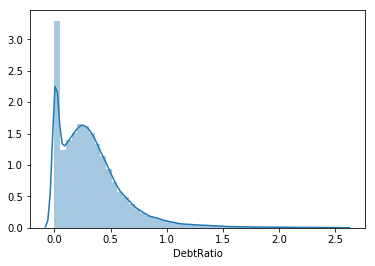

In [48]:
sns.distplot(ratios[ratios <= Q]);

**Decision, in two steps:**

- Where the **monthly income** is imputed, we divide the **debt ratio** by the new monthly gross income.

- Drop **debt ratios** at the upper 2% of the *new distribution*.

## Downsampling

As we seen before, this dataset is quite imbalanced:

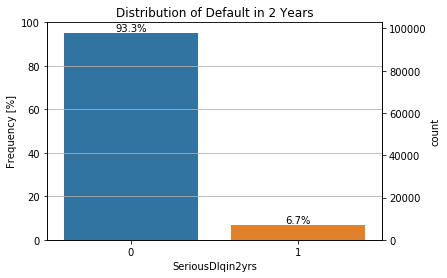

In [49]:
ax = sns.countplot(model_data.SeriousDlqin2yrs)
ax.set_title('Distribution of Default in 2 Years')
add_freq_axis(model_data, ax)

I will also downsample the good customers to be as twice as large as the bad ones.

,age,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime3059DaysPastDueNotWorse,NumberOfTime6089DaysPastDueNotWorse,NumberOfTimes90DaysLate,MonthlyIncome,DebtRatio,SeriousDlqin2yrs
0,73,NaN,0.082662,5,0,0,0,0,NaN,86.000000,0
1,79,0.0,0.027904,4,2,0,0,0,5627.0,0.434080,0
2,51,2.0,0.992436,12,2,4,2,2,7450.0,0.372433,0
3,35,2.0,0.379358,5,1,1,0,0,8500.0,0.281261,0
4,48,3.0,0.598569,8,1,0,0,0,1000.0,1.143856,0


Downsampled shape: (21138, 11)


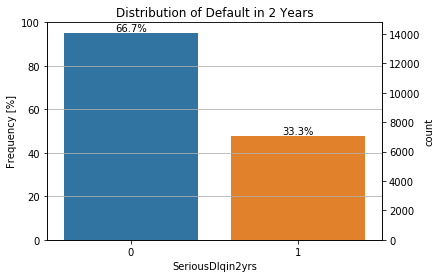

In [50]:
bad_count = np.sum(model_data.SeriousDlqin2yrs == 1)
resample = [bad_count * 2, bad_count]
downsampled_data = model_data.groupby('SeriousDlqin2yrs').apply(
    lambda g: g.sample(resample[g.SeriousDlqin2yrs.max()])).reset_index(drop=True)
display(downsampled_data.head())
print('Downsampled shape:', downsampled_data.shape)
ax = sns.countplot(downsampled_data.SeriousDlqin2yrs)
ax.set_title('Distribution of Default in 2 Years')
add_freq_axis(downsampled_data, ax)

**Decision:** do downsampling.

# Data Preparation

To prepare the data, we first split the `model_data` into a Train and Test set because `Prepare.fit()` needs to compute the median value, and we shall look only at the actual training data. Later on, we redo the same thing with the transformed data.

In [118]:
class Prepare(object):
    """
    Data Preparation class.  This should include everything necessary to prepare
    the dataset for execution after reading it.
    """
    def fit(self, X, y):
        self.age_outlier_fence_ = X.age.quantile(0.9999)
        self.age_median_ = X.age.median()
        self.real_state_median_ = X.NumberRealEstateLoansOrLines.median()
        self.montly_income_median_ = X.MonthlyIncome.median()
        self.debt_ratio_fence_ = None  # Computed in the transform
        
    def transform(self, X, is_training=True):
        """
        X should include the target column to drop rows correctly.
        Note, however, we cannot drop rows from non-training set.
        """
        result = X.copy()
        # Age
        if is_training:
            selected = np.where((result.age.values < 15) | (result.age.values >= self.age_outlier_fence_))
            result.drop(result.index[selected], inplace=True)
        else:
            mask = (result.age < 15) | (result.age >= self.age_outlier_fence_)
            result.age[mask] = self.age_median_
        # NumberOfDependents
        result.NumberOfDependents.fillna(0, inplace=True)
        # RevolvingUtilizationOfUnsecuredLines
        selected = np.where(result.RevolvingUtilizationOfUnsecuredLines.values > 1)
        result.RevolvingUtilizationOfUnsecuredLines.values[selected] = 1.1
        # NumberOfOpenCreditLinesAndLoans
        # NumberRealEstateLoansOrLines
        if is_training:
            selected = np.where(result.NumberRealEstateLoansOrLines.values >= 54)
            result.drop(result.index[selected], inplace=True)
        else:
            selected = np.where(result.NumberRealEstateLoansOrLines.values >= 54)
            result.NumberRealEstateLoansOrLines.values[mask] = self.real_state_median_            
        # NumberOfTime3059DaysPastDueNotWorse
        selected = np.where(result.NumberOfTime3059DaysPastDueNotWorse.values > 95)
        result.NumberOfTime3059DaysPastDueNotWorse.values[selected] = 0
        # NumberOfTime6089DaysPastDueNotWorse
        selected = np.where(result.NumberOfTime6089DaysPastDueNotWorse.values > 95)
        result.NumberOfTime6089DaysPastDueNotWorse.values[selected] = 0
        # NumberOfTimes90DaysLate
        selected = np.where(result.NumberOfTimes90DaysLate.values > 95)
        result.NumberOfTimes90DaysLate.values[selected] = 0
        # NumberOfTimes30DaysLate
        result['NumberOfTimes30DaysLate'] = \
            result.NumberOfTime3059DaysPastDueNotWorse + \
            result.NumberOfTime6089DaysPastDueNotWorse + \
            result.NumberOfTimes90DaysLate
        # MonthlyIncome
        null_income = np.where(np.isnan(result.MonthlyIncome.values))
        result.MonthlyIncome.fillna(self.montly_income_median_, inplace=True)
        # DebtRatio
        # 1 - Divide by imputed Monthly Income (the median)
        ratio = result.DebtRatio.values[null_income] / self.montly_income_median_
        result.DebtRatio.values[null_income] = ratio
        # 2 - Drop the upper 2%
        self.debt_ratio_fence_ = result.DebtRatio.quantile(0.98)
        if is_training:
            selected = np.where(result.DebtRatio.values > self.debt_ratio_fence_)
            result.drop(result.index[selected], inplace=True)
        else:
            selected = np.where(result.DebtRatio.values > self.debt_ratio_fence_)
            result.DebtRatio.values[selected] = self.debt_ratio_fence_
        # DiffIncomeExpense
        result['DiffIncomeExpense'] = \
            result.MonthlyIncome - result.DebtRatio * result.MonthlyIncome
        # Downsampling if in the training set
        if is_training:
            assert np.all(~result.SeriousDlqin2yrs.isnull())
            bad_count = np.sum(result.SeriousDlqin2yrs == 1)
            resample = [bad_count * 2, bad_count]
            result = result.groupby('SeriousDlqin2yrs').\
                apply(lambda g: g.sample(resample[g.SeriousDlqin2yrs.max()])).\
                reset_index(drop=True)
        return result

prep = Prepare()
prep.fit(*splits['train'])
transformed_data = prep.transform(raw)

splits = train_validate_test_split(*split_column(transformed_data, 'SeriousDlqin2yrs'))

**All:** (29589, 12) (29589,)

**Model:** (20712, 12) (20712,) — **Train:** (11835, 12) (11835,) — **Validate:** (8877, 12) (8877,)

**Test:** (8877, 12) (8877,)

## Principal Component Analysis

Let’s try plotting the first three Principal Components.

Explained variance ratio of the first 3 components: 96.2381% 3.7615% 0.0004%, sum: 100.00%


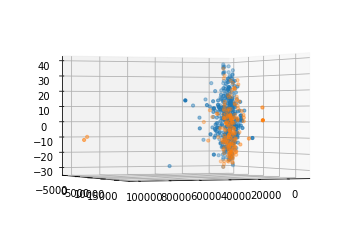

In [55]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3, svd_solver='full', random_state=seed)
X_train, y_train = splits['train']
X_pca_in = X_train.sample(600, random_state=seed).reset_index(drop=True)
y_pca_in = y_train.sample(600, random_state=seed).reset_index(drop=True)
X_pca = pca.fit(X_pca_in).transform(X_pca_in)
print('Explained variance ratio of the first 3 components: {:.4%} {:.4%} {:.4%}, sum: {:.2%}'.format(
      *pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)))
# I set "notebook" to interactively rotate the plot and find a best angle.
#%matplotlib notebook
#%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[y_pca_in == 0, 0], X_pca[y_pca_in == 0, 1], X_pca[y_pca_in == 0, 2], s=10)
ax.scatter(X_pca[y_pca_in == 1, 0], X_pca[y_pca_in == 1, 1], X_pca[y_pca_in == 1, 2], s=10)
ax.view_init(0, 67)
plt.show()

It’s not very separable using these first components.

## Correlation

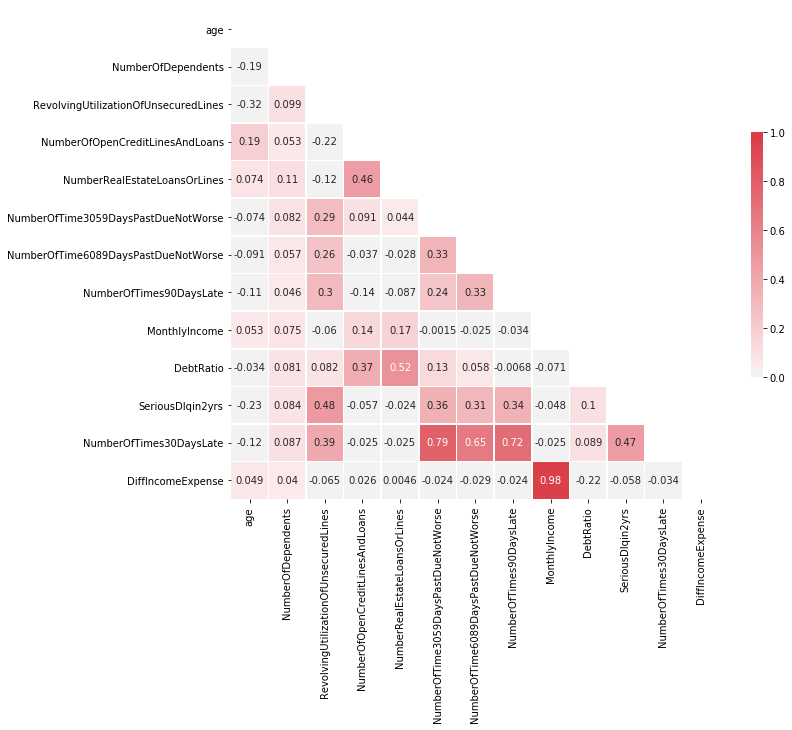

In [59]:
corr = transformed_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

The most correlated features with the response variable are:
    
- **RevolvingUtilizationOfUnsecuredLines**: 0.47

- **NumberOfTimes30DaysLate** (and its related features): 0.47 (0.36, 0.34, 0.34)

- **age**: -0.22

## Paired scatter plot

Let’s see the scatter plot of paired features with the distribution of each feature.

,Feature,Plot column
0,age,F0
1,NumberOfDependents,F1
2,RevolvingUtilizationOfUnsecuredLines,F2
3,NumberOfOpenCreditLinesAndLoans,F3
4,NumberRealEstateLoansOrLines,F4
5,NumberOfTime3059DaysPastDueNotWorse,F5
6,NumberOfTime6089DaysPastDueNotWorse,F6
7,NumberOfTimes90DaysLate,F7
8,MonthlyIncome,F8
9,DebtRatio,F9


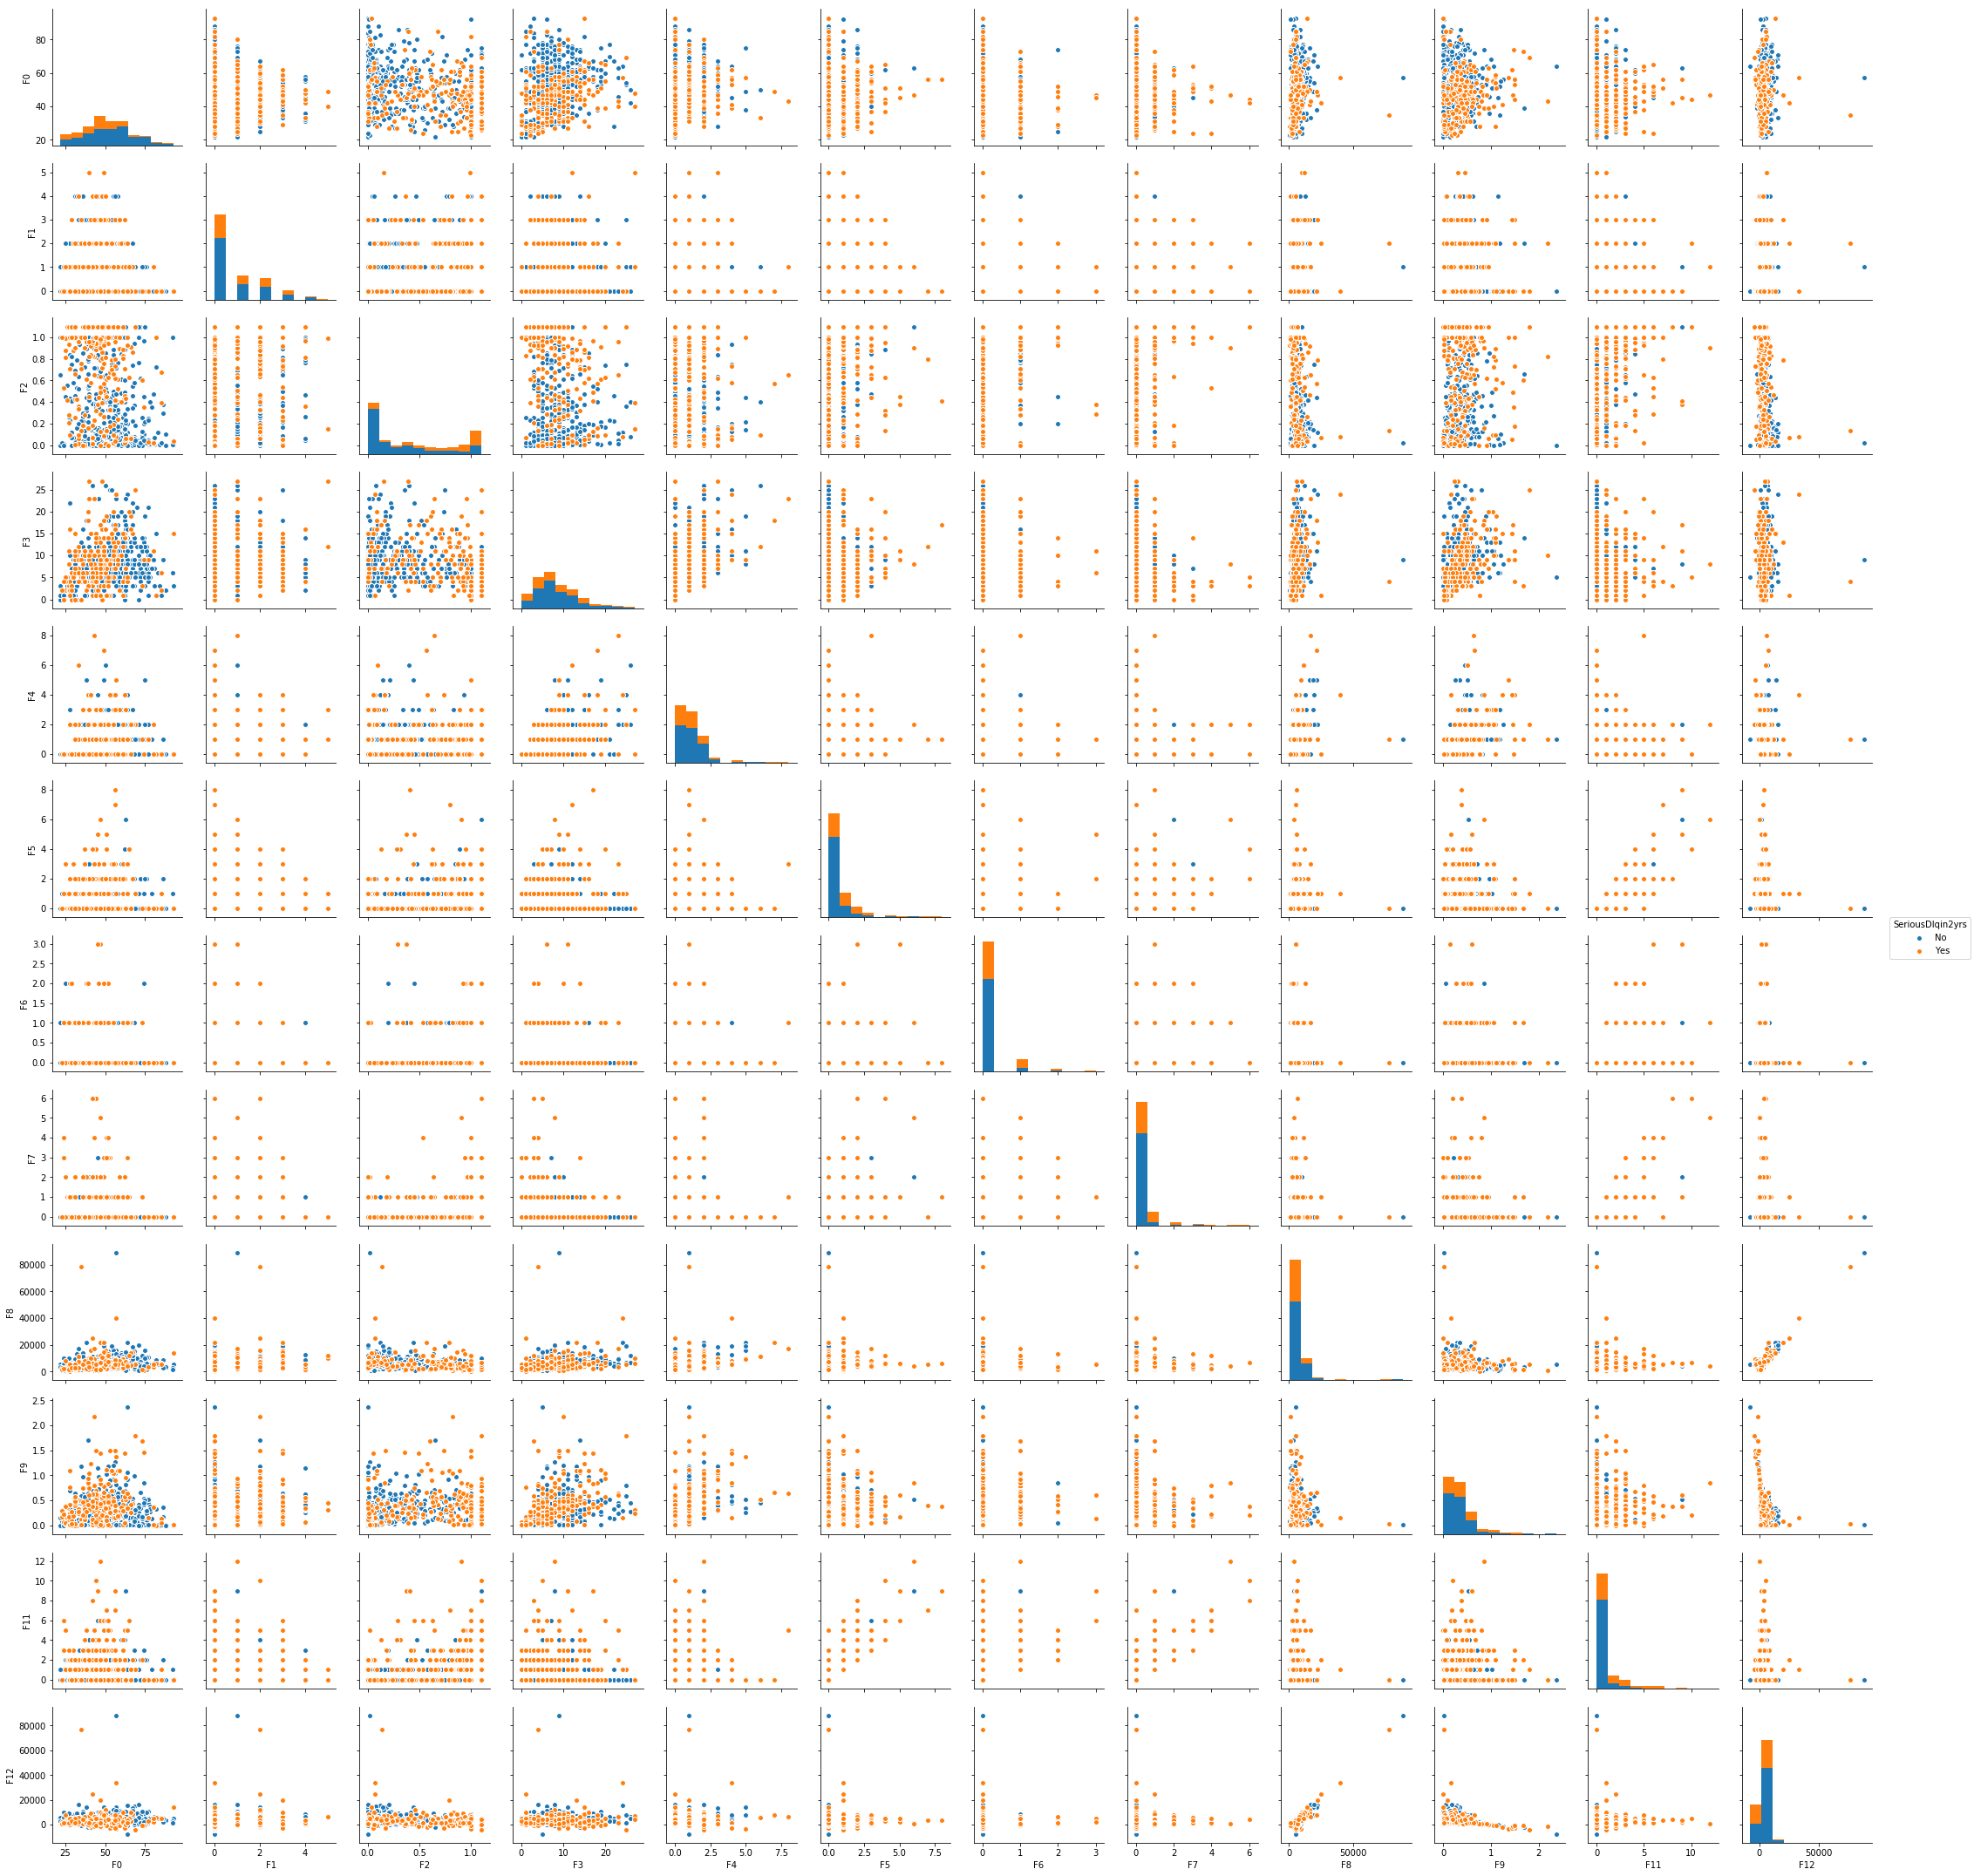

In [62]:
TARGET = 'SeriousDlqin2yrs'
# Sample
pp_data = transformed_data.groupby(TARGET).apply(lambda grp: grp.sample(frac=0.02)).copy()
# Convert column names to F0, F1, ..., except the target column, otherwise the label for
# each grid column will be too large.
target_index = np.where(pp_data.columns == TARGET)[0]
formatter = lambda i, name: 'F{}'.format(i) if name != TARGET else TARGET
pp_data.columns = [formatter(*col) for col in enumerate(pp_data.columns)]
# Convert the target values to string, to hide it from the grid and
# use only as a color information
pp_data[TARGET] = pp_data[TARGET].apply(lambda x: ['No', 'Yes'][x])
# Show the map of actual column to the new 'Fx'
display(pd.DataFrame({'Feature': transformed_data.columns, 
                      'Plot column': pp_data.columns}))
sns.pairplot(pp_data, hue=TARGET);

Visually, it seems younger people without dependents, and few credit lines are most likely to default. Let’s start bulding the models.

# Prediction Models

In [65]:
def best_threshold(expected, proba_predicted, pos_label=None):
    """
    Returns the best threshold to binarize |proba_predicted|, determined by
    |threshold| that yields the closest ROC curve’s point to the point (0, 1).
    """
    fpr, tpr, threshold = metrics.roc_curve(expected, proba_predicted,
                                            pos_label=pos_label)
    curve = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'threshold': threshold,
                          'distance': np.sqrt(fpr ** 2 + (tpr - 1) ** 2)})
    return curve['threshold'][np.argmin(curve['distance'])]

## One-feature, single-rule classifier

Let’s temporarily normalized each feature and treat it as probability. Then we’ll check their ROC AUCs, precision, and recall. We are aiming at better understanding the prediction capability of the feature independently.

In [66]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import binarize
from sklearn import metrics

def formatter(value, prec=3, inverse=False):
    """
    Format a number for a table, putting inversed scales into parenthesis.
    If the AUC was less than 0.5, I inverse the scale of the variable, such
    that instead the |threshold| represent a binarization (0, threshold, 1),
    it becomes (1, threshold, 0) — that is, values below threshold become 1
    and values above become 0.  This is represented with a parenthesis on the
    table.
    """
    fmt = '{{:.{}}}'.format(prec)
    str_val = fmt.format(value)
    if inverse:
        return '({})'.format(str_val)
    return str_val

class OneRuleExplorer(object):
    """
    Creates one classifier for each feature. A classifier is simply one rule
    of “response = feature > threshold? 1: 0”. The threshold is determined by
    the True Positive Rate (TPR) × False Positive Rate (TPR).
    First, we look to the ROC AUC to see whether the AUC > 0.5. If the area 
    is below, we flip the feature order so that the new AUC' = 1 - AUC.
    Then, we find the best threshold for this variable and compute the precision
    and recall for that threshold level.    
    """
    
    def classify(self, colname, x, y):
        norm = minmax_scale(x)
        # Compute AUC and mark whether we should invert the result
        auc = metrics.roc_auc_score(y, norm)
        inverse = auc < 0.5
        if inverse:
            norm = (1 - norm)
            auc = metrics.roc_auc_score(y, norm)
        # Inverse of minmax_scale
        unscale = lambda x: x * np.ptp(x) + x.min()
        if inverse:
            unscale = lambda scaled: (1 - scaled) * np.ptp(x) + x.min()
        # Set the best threshold for this variable according the ROC Curve
        thresh = best_threshold(y, norm)
        thresh_val = unscale(thresh)
        # Compute the precision and recall
        binary = binarize(norm.reshape(-1, 1) , thresh).reshape(-1, 1)     
        prec = metrics.precision_score(y, binary)
        recall = metrics.recall_score(y, binary)
        # Add a row for this column
        self.results.append(pd.DataFrame(dict(
            Feature=[colname], NumAUC=[auc], 
            AUC=[formatter(auc, inverse=inverse)],
            Precision=[formatter(prec, inverse=inverse)], 
            Recall=[formatter(recall, inverse=inverse)], 
            Threshold=[formatter(thresh, 2, inverse=inverse)], 
            Threshold_Value=[formatter(thresh_val, 5, inverse=inverse)])))
    
    def explore(self, X, y):
        """
        Returns a table where each row is the result for a one-feature classifier.
        The table is sorted descending by the AUC.
        Values in parenthesis mean the feature values where reversed, which would be
        equivalent to do new_value = max(value) - value.
        The |threshold| is the level determined to binarize values.
        """
        self.results = []
        for col in X.columns:
            self.classify(col, X[col].astype(np.float64), y)
        result = pd.concat(self.results).set_index('Feature'). \
            sort_values('NumAUC', ascending=False).drop('NumAUC', axis=1)
        return result
        
OneRuleExplorer().explore(X_train, y_train)

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Precision,Recall,Threshold,Threshold_Value
Feature,,,,,
RevolvingUtilizationOfUnsecuredLines,0.78,0.579,0.733,0.41,0.40531
NumberOfTimes30DaysLate,0.766,0.781,0.448,0.056,0.055556
NumberOfTime3059DaysPastDueNotWorse,0.679,0.743,0.239,0.077,0.076923
NumberOfTimes90DaysLate,0.651,0.908,0.16,0.059,0.058824
age,(0.638),(0.427),(0.589),(0.63),(49.0)
NumberOfTime6089DaysPastDueNotWorse,0.614,0.899,0.081,0.12,0.125
DiffIncomeExpense,(0.595),(0.402),(0.561),(0.98),(3403.4)
MonthlyIncome,(0.58),(0.399),(0.495),(1.0),(5308.0)
NumberOfOpenCreditLinesAndLoans,(0.556),(0.406),(0.399),(0.89),(6.0)


In this table above, we have the result for one one-feature–classifier by time. For each row, we have the Area Under the Curve for the ROC curve, along with the *precision* and the *recall* for the respective *threshold*. The *threshold value* is the actual value unscaled from the min–max scaler. Whenever the relationship with the target variable is inverse — when the AUC < 0.5 for that variable — we invert the output probability to compute the metrics. This is denoted with parenthesis: **age** with AUC = (0.635) means that customers younger than 49 years-old have higher probability of default than otherwise. We can also see that

- **RevolvingUtilizationOfUnsecuredLines** and **NumberOfTimes30DaysLate** have very good AUC ROCs.
- **RevolvingUtilizationOfUnsecuredLines** also has the highest *recall*, of 73.3%.
- The new feature **NumberOfTimes90DaysLate** has the highest *precision*, of 86.2%, but note how low is its *threshold*.
- As mentioned above, the **age** is inversed, meaning the younger the customer, the higher is the default risk, with the *threshold value* set at 49 years old.

## Logistic Regression

Continuing exploring features independently, let’s plot the main effects plot for each independent variable. Here, we want understand the effects, that is, the relationship between each independent variable and the dependent variable using a logistic regression for each variable.

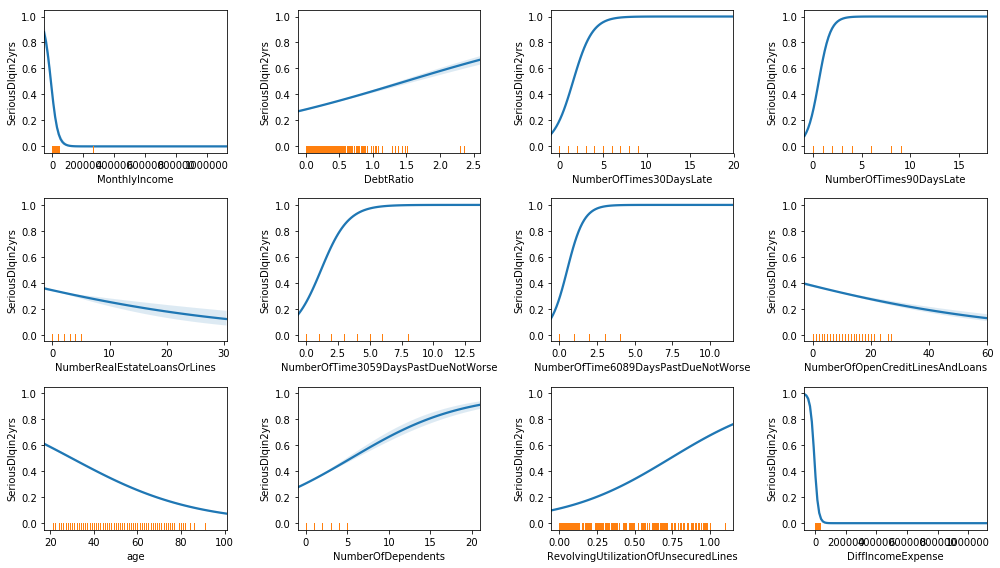

In [68]:
# seaborn.lmplot(logistic=True) requires statsmodels
import statsmodels

# Because we are fitting a logistic regression for each variable, this will take a while.
fig, ax = plt.subplots(3, 4, figsize=(14, 8))
for i, col in enumerate(transformed_data.drop('SeriousDlqin2yrs', axis=1).columns):
    plt.sca(ax[2 - (i + 1) // 4][i % 4])
    # You may also try robust=True if you have time.
    sns.regplot(x=col, y='SeriousDlqin2yrs', data=transformed_data, n_boot=30, logistic=True,
                scatter_kws={"color": "white"})
    sns.distplot(transformed_data[col].sample(300), rug=True, hist=False, kde=False)
    
plt.tight_layout()

Each plot has a Confidence Interval of 95%.  The probability of `SeriousDlqin2yrs` is shown on the y-axis while the values of each independent variable are on the x-axis.

In [79]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def roc_auc(model, X, y):
    return metrics.roc_auc_score(y, model.predict_proba(X)[:, 1])

def roc_auc_train_validate(model):
    return [roc_auc(model, *splits[setname]) for setname in ['train', 'validate']]

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('scaler', StandardScaler()),
                  #('logisticcv', LogisticRegressionCV(
                  #    Cs=100,
                  #    class_weight=None,
                  #    cv=StratifiedKFold(10),
                  #    solver='newton-cg',
                  #    penalty='l2',
                  #    scoring='roc_auc',
                  #    n_jobs=8,
                  #    fit_intercept=True)
                  ('logistic', LogisticRegression(C=0.06734151))
                ])

model = model.fit(*splits['train'])
print(roc_auc_train_validate(model))

[0.85989713038643401, 0.85847055748927403]


# XGBoost

In [95]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('scaler', StandardScaler()),
                  ('xgboost', xgb.XGBClassifier(learning_rate=0.01, n_estimators=10000, n_jobs=-1))
                ])


model.fit(*splits['train'])
print(roc_auc_train_validate(model))

[0.95468425277723923, 0.85762950159307028]


Overfitting.

### Log loss

In [241]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import StratifiedKFold
import logging

cv = StratifiedKFold(5)
cv_splits = cv.split(*splits['train'])

transformer = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('scaler', StandardScaler())
                 ])

X_train, y_train = splits['train']
X_validate, y_validate = splits['validate']

X_train = pd.DataFrame(transformer.fit_transform(X_train))
X_validate = pd.DataFrame(transformer.fit_transform(X_validate))

logging.basicConfig(filename='xgboost.log', level=logging.INFO)

def optimize(trials):
    space = {
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1500, 5)),
        'learning_rate': hp.qloguniform('learning_rate', np.log(0.001), np.log(0.1), 0.002),
        'gamma': hp.loguniform('gamma', np.log(1e-10), np.log(1e1)),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-10), np.log(1e1)),
        'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-10), np.log(1e1)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(1e-10), np.log(1e2)),
        'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
        'subsample': hp.quniform('subsample', 0.1, 1, 0.05),
        'colsample_bytree': 1,
        'colsample_bylevel': hp.quniform('colsample_bylevel', 0.1, 1, 0.05),
        'scale_pos_weight': hp.choice('scale_pos_weight', [1, np.sum(y_train == 0) / np.sum(y_train == 1)]),
        #'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'nthread': 8,
        'silent': 1
    }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    print(best)

    
def score(params):
    logging.info('Training with params: {}'.format(params))
    results = list()
    n_estimators = list()
    model.set_params(**params)
    for train, test in cv_splits:
        inner_x_train, inner_y_train = X_train.iloc[train], y_train.iloc[train]
        inner_x_test, inner_y_test = X_train.iloc[test], y_train.iloc[test]
        model.fit(inner_x_train, inner_y_train, 
                  eval_set=[(inner_x_train, inner_y_train), 
                            (inner_x_test, inner_y_test)],
                  eval_metric=['auc'],
                  early_stopping_rounds=50,
                  verbose=False)
        pred_train = model.predict_proba(inner_x_train)[:, 1]
        train_auc = metrics.roc_auc_score(inner_y_train, pred_train)
        results.append(train_auc)
        n_estimators.append(model.best_iteration)
    model.set_params(n_estimators=n_estimators[np.argmax(results)])
    model.fit(X_train, y_train)

    #pred_train = model.predict_proba(X_train)[:, 1]
    #train_auc = metrics.roc_auc_score(y_train, pred_train)
        
    mean_auc = np.mean(results)        
    pred_valid = model.predict_proba(X_validate)[:, 1]
    valid_auc = metrics.roc_auc_score(y_validate, pred_valid)
    logloss = metrics.log_loss(y_validate, pred_valid)
    display(Markdown('**Validate AUC:** {:.4} — **Mean Train AUC:** {:.4f} ± {:.4f} — **Logloss:** {:.4}\n'.format(
            valid_auc, mean_auc, np.std(mean_auc), logloss)))
    logging.info('Validate AUC: {:.4} — Mean Train AUC: {:.4f} ± {:.4f} — Logloss: {:.4}\n'.format(
            valid_auc, mean_auc, np.std(mean_auc), logloss))
    return {'loss': 1 - mean_auc, 'status': STATUS_OK}

model = xgb.XGBClassifier(n_jobs=-1)
    
trials = Trials()
optimize(trials)

**Validate AUC:** 0.855 — **Mean Train AUC:** 0.9146 ± 0.0000 — **Logloss:** 0.4778


ValueError: attempt to get argmax of an empty sequence

In [ ]:
trials

# Make Submission

In [90]:
model = xgb.XGBClassifier(learning_rate=0.01, n_estimators=10000, n_jobs=-1)
model.fit(*splits['model'])
print(roc_auc(model, *splits['test']))

0.85908888306


In [ ]:
from sklearn.externals import joblib

def make_submission(classifier, preparer, submission_name=None):
    """Loads the test set, applies all modifications and runs the model"""
    data = read_dataset('data/cs-test.csv', drop_cols='SeriousDlqin2yrs', verbose=1)
    transformed = preparer.transform(data, is_training=False)
    prob = model.predict_proba(transformed)[:, 1]
    submission = pd.DataFrame({'Id': np.arange(1, data.shape[0] + 1),
                               'Probability': prob})
    if submission_name:
        print('Writing {}.csv and {}.pkl'.format(*[submission_name] * 2))
        submission.to_csv('{}.csv', index=False)
        joblib.dump(classifier, '{}.pkl'.format(submission_name)) 
    return submission

make_submission(model, prep);